In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ROOT_DIR  = '/content/drive/MyDrive/Data/MVTecAD'  # 데이터셋 상위 경로
SAVE_NAME = f'best_skipgan.pt'

# =============================================================
# 0.  의존성 & 전역 설정
# =============================================================
import os, random, time
from glob   import glob
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.metrics import roc_auc_score
from torch.nn.utils import spectral_norm
import torch.autograd as autograd

IMG_SIZE   = 256
BATCH_SIZE = 16
EPOCHS     = 15
LR_G, LR_D = 5e-5, 1e-5
BETAS = (0.5, 0.999)
lambda_GP = 0.0 #spectral norm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('✅ device:', DEVICE)

# =============================================================
# 1.  데이터셋 & DataLoader
# =============================================================
class MVTecADMulti(Dataset):
    """
    지정한 카테고리만 스캔하도록 수정됨
      · phase='train' → bottle/train/good   (label=0)
      · phase='test'  → bottle/test/good      (label=0)
                        bottle/test/<defect>/*(label=1)
    """
    def __init__(self, root_dir:str, phase:str='train'):
        assert phase in ('train', 'test')
        self.phase = phase
        self.paths = []  # (img_path, label)

        # 'bottle' 카테고리 경로만 직접 지정
        cat_path = Path(root_dir) / 'bottle'

        if not cat_path.is_dir():
            # 'bottle' 폴더가 없을 경우 오류 발생
            raise FileNotFoundError(f"지정된 경로에 'bottle' 폴더가 없습니다: {cat_path}")

        if phase == 'train':
            # 훈련 데이터: 정상(good) 샘플만 로드
            self.paths += [(p, 0) for p in glob(str(cat_path / 'train' / 'good' / '*.png'))]
        else:  # 'test'
            # 테스트 데이터: 정상(good) 샘플 로드
            self.paths += [(p, 0) for p in glob(str(cat_path / 'test' / 'good' / '*.png'))]
            # 테스트 데이터: 비정상(defect) 샘플들 로드
            for defect in os.listdir(cat_path / 'test'):
                if defect == 'good':
                    continue
                defect_path = cat_path / 'test' / defect
                self.paths += [(p, 1) for p in glob(str(defect_path / '*.png'))]

        self.tf = T.Compose([
            T.ToPILImage(),
            T.Resize((IMG_SIZE, IMG_SIZE)),
            T.ToTensor(),
            T.Normalize([0.5] * 3, [0.5] * 3)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path, label = self.paths[idx]
        img = plt.imread(img_path)
        if img.ndim == 2:  # grayscale → 3-ch
            img = np.stack([img] * 3, -1)
        if img.max() <= 1:  # [0,1] → [0,255]
            img = (img * 255).astype(np.uint8)
        # ❗ [수정] 이미지 경로를 함께 반환
        return self.tf(img), label, img_path


def get_loaders_all(root_dir):
    train_ds = MVTecADMulti(root_dir, 'train')
    test_ds  = MVTecADMulti(root_dir, 'test')

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    # ❗ [수정] 테스트 시에는 데이터를 섞지 않도록 shuffle=False로 변경
    test_loader  = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader



✅ device: cuda


In [3]:
# =============================================================
# 2.  네트워크 정의 (Skip-GANomaly)
# =============================================================
# ------------------------------------------------
# 공통 초기화 함수
# ------------------------------------------------
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ------------------------------------------------
# Generator  (Skip-GANomaly)
# ------------------------------------------------
class DownBlock(nn.Module):
    """Conv(stride=2) → BN → LeakyReLU"""
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x): return self.net(x)

class UpBlock(nn.Module):
    """ConvTranspose(stride=2) → BN → ReLU"""
    def __init__(self, c_in, c_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
        )
    def forward(self, x): return self.net(x)

class Generator(nn.Module):
    """
    • 인코더  : 3→64→128→256→512 (4-스탭)
    • 디코더  : 512→256→128→64 (3-스탭) + 최종 Conv
    • skip 연결: 동일 해상도 레이어끼리 concat
    """
    def __init__(self, base=64):
        super().__init__()
        # ---- Encoder ----
        self.e1 = DownBlock(3,      base)         # 256 → 128
        self.e2 = DownBlock(base,   base*2)       # 128 → 64
        self.e3 = DownBlock(base*2, base*4)       #  64 → 32
        self.e4 = DownBlock(base*4, base*8)       #  32 → 16

        # ---- Bottleneck ----  (stride-1 conv 두 번)
        self.bottle = nn.Sequential(
            nn.Conv2d(base*8, base*8, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(base*8, base*8, 3, 1, 1, bias=False),
            nn.ReLU(),
        )

        # ---- Decoder ----
        self.d3 = UpBlock(base*8,   base*4)       # 16 → 32
        self.d2 = UpBlock(base*8,   base*2)       # 32 → 64   (skip concat)
        self.d1 = UpBlock(base*4,   base)         # 64 → 128  (skip concat)

        # ---- Output (복원 이미지) ----
        self.out_conv = nn.Sequential(
            nn.ConvTranspose2d(base*2, 3, 4, 2, 1, bias=False),  # 128 → 256
            nn.Tanh(),
        )

        self.apply(weights_init)

    def forward(self, x):
        # Encoder
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)

        # Bottleneck
        b  = self.bottle(e4)

        # Decoder + skip
        d3 = self.d3(b)              # 16→32
        d3 = torch.cat([d3, e3], 1)  # 256 + 256 = 512

        d2 = self.d2(d3)             # 32→64
        d2 = torch.cat([d2, e2], 1)  # 128 + 128 = 256

        d1 = self.d1(d2)             # 64→128
        d1 = torch.cat([d1, e1], 1)  # 64 + 64 = 128

        out = self.out_conv(d1)      # 128→256
        return out                   # [-1,1] 범위 (tanh)

# ------------------------------------------------
# Discriminator  (PatchGAN + Feature extraction)
# ------------------------------------------------
class Discriminator(nn.Module):
    """
    • Conv stride-2 를 5단 쌓아 16×16 패치 단위 판별 (256 입력 기준)
    • WGAN GP / LSGAN 등 어떤 GAN 로스에도 바로 사용 가능
    • return_feat=True 시 encoder stage 평균값을 concat → feature vector
    """
    def __init__(self, base=64):
        super().__init__()
        def dblk(c_in, c_out, bn=True):
            layers = [spectral_norm(nn.Conv2d(c_in, c_out, 4, 2, 1, bias=False))]
            if bn: layers.append(nn.BatchNorm2d(c_out))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.stem = nn.Sequential(
            dblk(3,      base,   bn=False),  # 256 → 128
            dblk(base,   base*2),            # 128 → 64
            dblk(base*2, base*4),            # 64  → 32
            dblk(base*4, base*8),            # 32  → 16
            dblk(base*8, base*8),            # 16  → 8
        )
        self.out_conv = spectral_norm(nn.Conv2d(base*8, 1, 4, 1, 0))  # 8→1

        self.apply(weights_init)

    def forward(self, x, return_feat=False):
        feats = []
        h = x
        for layer in self.stem:
            h = layer(h)
            feats.append(h)

        score = self.out_conv(h).view(-1)   # PatchGAN: (B)
        if return_feat:
            # 각 stage feature map 평균 → concat (Skip-GANomaly loss용)
            fvec = torch.cat([f.mean([2, 3]) for f in feats], dim=1)
            return score, fvec
        return score

In [4]:
# =============================================================
# 3.  학습 루프 & 평가 함수
# =============================================================
L_adv, L_rec, L_fm = nn.BCEWithLogitsLoss(), nn.L1Loss(), nn.L1Loss()

def gradient_penalty(D, real, fake):
    a_weights = torch.rand(real.size(0),1,1,1, device=real.device)
    inter = (a_weights*real + (1-a_weights)*fake).requires_grad_(True)
    score = D(inter)
    grad  = autograd.grad(outputs=score, inputs=inter,
                          grad_outputs=torch.ones_like(score),
                          create_graph=True, retain_graph=True)[0]
    gp = ((grad.view(grad.size(0), -1).norm(2, dim=1) - 1)**2).mean()
    return gp

def train_epoch(G,D,loader,optG,optD,lambda_rec=50,lambda_fm=10):
    G.train(); D.train(); g_tot=d_tot=0
    for imgs, _, _ in tqdm(loader, leave=False):
        imgs = imgs.to(DEVICE)

        # --- D (maximize real-fake gap) ---
        optD.zero_grad()
        fake = G(imgs).detach()
        d_real = D(imgs)
        d_fake = D(fake)
        gp = gradient_penalty(D, imgs, fake)
        d_loss = -(d_real.mean() - d_fake.mean()) + lambda_GP*gp
        d_loss.backward(); optD.step()

        # --- G (fool D + recon + feature-match) ---
        optG.zero_grad()
        fake = G(imgs)
        g_adv = -D(fake).mean()                     # WGAN generator loss
        _, feat_f = D(fake, True)
        _, feat_r = D(imgs, True)
        g_rec = L_rec(fake, imgs)
        g_fm  = L_fm(feat_f, feat_r.detach())
        g_loss = g_adv + lambda_rec*g_rec + lambda_fm*g_fm
        g_loss.backward(); optG.step()

        g_tot += g_loss.item();  d_tot += d_loss.item()
    n=len(loader); return g_tot/n, d_tot/n

@torch.inference_mode()
def get_scores(G, loader):
    G.eval(); scores=[]; labels=[]
    for imgs, lbl, _ in loader:
        imgs = imgs.to(DEVICE)
        err  = torch.mean((G(imgs) - imgs).abs(), dim=[1,2,3])
        scores += err.cpu().tolist(); labels += lbl
    return np.array(scores), np.array(labels)

def fit_all(root_dir, save_path_g, save_path_d):
    """
    모델을 학습하고, 가장 성능이 좋았던 시점의
    Generator(G)와 Discriminator(D) 모델 객체를 반환합니다.
    """
    tl, vl = get_loaders_all(root_dir)
    G, D = Generator().to(DEVICE), Discriminator().to(DEVICE)
    optG = torch.optim.Adam(G.parameters(), LR_G, betas=BETAS)
    optD = torch.optim.Adam(D.parameters(), LR_D, betas=BETAS)

    best_auc = 0
    best_G_state = None
    best_D_state = None # [추가] 최고 성능 D의 가중치를 저장할 변수

    for ep in range(1, EPOCHS+1):
        g, d = train_epoch(G, D, tl, optG, optD)
        s, l = get_scores(G, vl)
        auc = roc_auc_score(l, s)

        if auc > best_auc:
            best_auc = auc
            # [수정] G와 D의 가중치를 함께 저장
            best_G_state = copy.deepcopy(G.state_dict())
            best_D_state = copy.deepcopy(D.state_dict())
            torch.save(best_G_state, save_path_g)
            torch.save(best_D_state, save_path_d)

        print(f'[Ep {ep:03d}] G:{g:.3f}  D:{d:.3f}  AUC:{auc:.4f} (best {best_auc:.4f})')

    print(f'\nDone! best AUC: {best_auc:.4f}')

    # [수정] G와 D 모두에 최고 성능 가중치를 로드
    if best_G_state and best_D_state:
        G.load_state_dict(best_G_state)
        D.load_state_dict(best_D_state)

    # [수정] G와 D 모델 객체를 모두 반환
    return G, D


In [5]:
# =============================================================
# 4.  학습 실행
# =============================================================

# G와 D의 저장 경로를 각각 정의합니다.
G_SAVE_NAME = 'best_skipgan_all.pt'
D_SAVE_NAME = 'best_skipgan_all_D.pt'

# 2개의 저장 경로를 모두 인자로 전달합니다.
best_G, best_D = fit_all(ROOT_DIR, G_SAVE_NAME, D_SAVE_NAME)

  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 001] G:23.588  D:1.077  AUC:0.3508 (best 0.3508)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 002] G:10.904  D:1.565  AUC:0.1603 (best 0.3508)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 003] G:4.554  D:1.816  AUC:0.2984 (best 0.3508)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 004] G:1.722  D:1.601  AUC:0.3302 (best 0.3508)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 005] G:0.329  D:1.173  AUC:0.3556 (best 0.3556)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 006] G:-0.491  D:0.832  AUC:0.3770 (best 0.3770)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 007] G:-1.044  D:0.606  AUC:0.3960 (best 0.3960)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 008] G:-1.439  D:0.456  AUC:0.4214 (best 0.4214)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 009] G:-1.750  D:0.354  AUC:0.4357 (best 0.4357)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 010] G:-1.995  D:0.283  AUC:0.4516 (best 0.4516)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 011] G:-2.196  D:0.231  AUC:0.4508 (best 0.4516)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 012] G:-2.358  D:0.195  AUC:0.4595 (best 0.4595)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 013] G:-2.502  D:0.168  AUC:0.4817 (best 0.4817)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 014] G:-2.617  D:0.146  AUC:0.4579 (best 0.4817)


  0%|          | 0/13 [00:00<?, ?it/s]

[Ep 015] G:-2.714  D:0.128  AUC:0.4556 (best 0.4817)

Done! best AUC: 0.4817


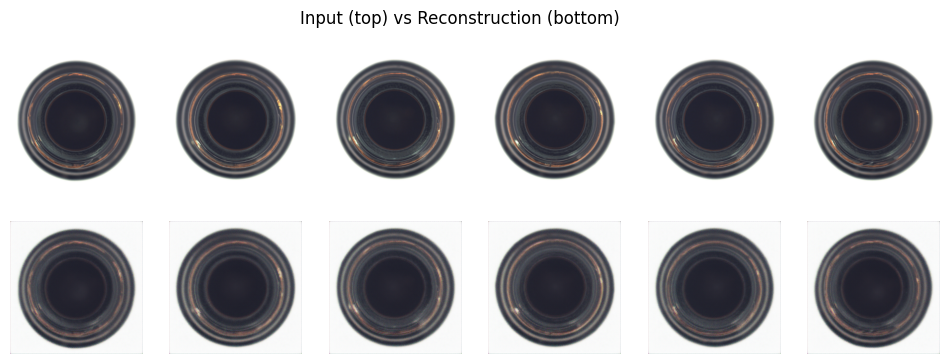

✔ 정상(good)   : 20
✔ 이상(defect) : 63


In [6]:
# =============================================================
# 5.  재구성 시각화 (학습 후)
# =============================================================
SAVE_NAME = '/content/best_skipgan_all.pt'

@torch.inference_mode()
def show_recon(G, loader, n=6):
    G.eval()
    imgs, _, _ = next(iter(loader))
    imgs = imgs[:n].to(DEVICE)

    recon = G(imgs)
    imgs, recon = imgs.cpu()*0.5+0.5, recon.cpu()*0.5+0.5
    plt.figure(figsize=(n*2,4))
    for i in range(n):
        plt.subplot(2,n,i+1);     plt.imshow(imgs[i].permute(1,2,0));   plt.axis('off')
        plt.subplot(2,n,n+i+1);   plt.imshow(recon[i].permute(1,2,0));  plt.axis('off')
    plt.suptitle('Input (top) vs Reconstruction (bottom)'); plt.show()

# 💡 사용 예: 파일 로드 과정 없이, 위에서 반환받은 `best_G_model`을 즉시 사용
_, test_loader = get_loaders_all(ROOT_DIR)
show_recon(best_G, test_loader)

# 전체 데이터셋에 대해 정상/이상 개수 확인
num_norm = sum(1 for _, y, _ in test_loader.dataset if y == 0)
num_anom = sum(1 for _, y, _ in test_loader.dataset if y == 1)
print(f"✔ 정상(good)   : {num_norm:,}")
print(f"✔ 이상(defect) : {num_anom:,}")

In [7]:
# 전체 데이터셋에 대해 정상/이상 개수 확인
num_norm = sum(1 for path, label in test_loader.dataset.paths if label == 0)
num_anom = sum(1 for path, label in test_loader.dataset.paths if label == 1)
print(f"✔ 정상(good)   : {num_norm:,}")
print(f"✔ 이상(defect) : {num_anom:,}")


✔ 정상(good)   : 20
✔ 이상(defect) : 63


Testing:   0%|          | 0/6 [00:00<?, ?it/s]

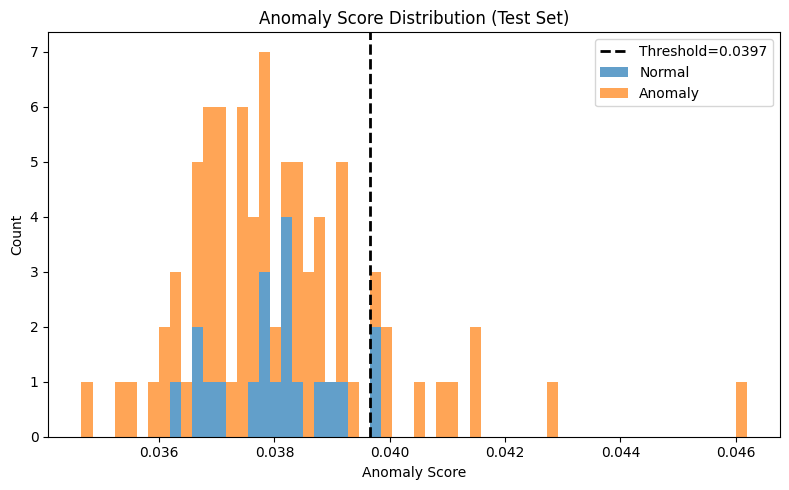

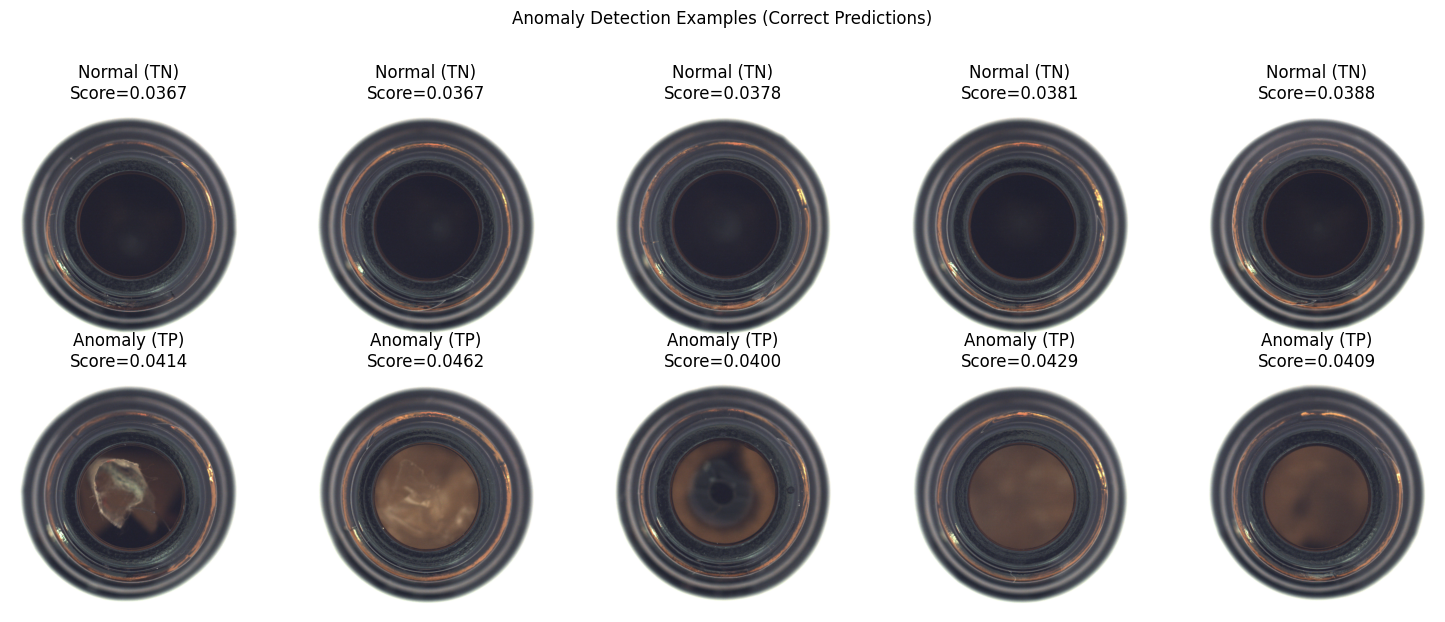

In [8]:
# =============================================================
# 6.  테스트 & 시각화
# =============================================================
import torch.nn.functional as F

# ❗ [수정] 파일 로드 블록 전체를 삭제하고,
# 이전 단계에서 반환받은 모델 객체를 즉시 사용합니다.
best_G.eval()
best_D.eval()

# Anomaly Score 계산을 위한 가중치 (lambda)
LAMBDA_SCORE = 0.1

# ② 테스트 데이터셋 전체에 대해 Anomaly Score 계산
scores, labels, paths = [], [], []
with torch.no_grad():
    # test_loader는 미리 로드되어 있어야 합니다.
    _, test_loader = get_loaders_all(ROOT_DIR)

    for imgs, lbls, batch_paths in tqdm(test_loader, 'Testing'):
        imgs_gpu = imgs.to(DEVICE)

        # 1. 재구성 이미지 생성 (best_G 사용)
        recons = best_G(imgs_gpu)

        # 2. 재구성 오차 (L_con) 계산: |x - G(x)|
        err_rec = torch.mean(torch.abs(imgs_gpu - recons), dim=[1,2,3])

        # 3. 판별자 특징 추출 (best_D 사용)
        _, feat_real = best_D(imgs_gpu, return_feat=True)
        _, feat_fake = best_D(recons, return_feat=True)

        # 4. 특징 공간 오차 (L_enc) 계산: |f_D(x) - f_D(G(x))|
        err_enc = torch.mean(torch.abs(feat_real - feat_fake), dim=1)

        # 5. 최종 이상치 점수 계산
        batch_scores = (1 - LAMBDA_SCORE) * err_rec + LAMBDA_SCORE * err_enc

        scores.append(batch_scores.cpu().numpy())
        labels.append(lbls.numpy())
        paths += batch_paths

scores = np.concatenate(scores)
labels = np.concatenate(labels)


# ③ 결과를 바탕으로 시각화 (이하 로직은 동일)
# 정상 데이터의 점수 분포에서 95% 지점을 임계값으로 설정
THRESH = np.percentile(scores[labels == 0], 95)

# ---------- (1) 점수 분포 시각화 ----------
hist_n, edges = np.histogram(scores[labels == 0], bins=60, range=(scores.min(), scores.max()))
hist_a, _     = np.histogram(scores[labels == 1], bins=edges)
centers       = (edges[:-1] + edges[1:]) / 2
bar_width     = centers[1] - centers[0]

plt.figure(figsize=(8, 5))
plt.bar(centers, hist_n, width=bar_width, label='Normal',  alpha=.7)
plt.bar(centers, hist_a, width=bar_width, label='Anomaly', alpha=.7, bottom=hist_n)
plt.axvline(THRESH, ls='--', lw=2, color='k', label=f'Threshold={THRESH:.4f}')
plt.xlabel('Anomaly Score'); plt.ylabel('Count')
plt.title ('Anomaly Score Distribution (Test Set)'); plt.legend()
plt.tight_layout(); plt.show()


# ---------- (2) 정상·이상 판별 예시 시각화 ----------
def pick_idxs(labels, scores, thresh, n_each=5):
    # 정상으로 판별된 정상 샘플 (True Negative)
    idx_norm = np.where((labels == 0) & (scores < thresh))[0]
    # 이상으로 판별된 이상 샘플 (True Positive)
    idx_anom = np.where((labels == 1) & (scores > thresh))[0]

    # 각 그룹에서 n_each개씩 랜덤으로 선택
    # 샘플 수가 부족할 경우를 대비해 replace=True 설정
    sel_norm = np.random.choice(idx_norm, n_each, replace=len(idx_norm) < n_each)
    sel_anom = np.random.choice(idx_anom, n_each, replace=len(idx_anom) < n_each)

    return np.concatenate([sel_norm, sel_anom])

# 시각화할 샘플 인덱스 선택
sel_indices = pick_idxs(labels, scores, THRESH, 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6.5))
axes = axes.flatten()
for i, idx in enumerate(sel_indices):
    img = plt.imread(paths[idx])[..., :3]
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')

    # 앞 5개는 Normal, 뒤 5개는 Anomaly
    label_str = 'Normal (TN)' if i < 5 else 'Anomaly (TP)'
    ax.set_title(f"{label_str}\nScore={scores[idx]:.4f}")

plt.suptitle('Anomaly Detection Examples (Correct Predictions)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
